In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

In [2]:
# reading the csv file
df = pd.read_csv("../data/BrentOil.csv")
df.head(10)

,Date,Price,year,month,day
0,1987-05-20,18.63,1987,5,20
1,1987-05-21,18.45,1987,5,21
2,1987-05-22,18.55,1987,5,22
3,1987-05-25,18.60,1987,5,25
4,1987-05-26,18.63,1987,5,26
5,1987-05-27,18.60,1987,5,27
6,1987-05-28,18.60,1987,5,28
7,1987-05-29,18.58,1987,5,29
8,1987-06-01,18.65,1987,6,1
9,1987-06-02,18.68,1987,6,2


In [3]:
X = df.drop(columns=['Price', 'Date'])

In [4]:
def guassian_posterior(X, theta):
    # returns the unnormalized log posterior
    # logprior represents the log of the prior probability density function evaluated at theta
    loglik = np.sum(np.log(st.norm(loc=theta, scale=1).pdf(X)))
    logprior = np.log(st.norm(loc=0, scale=1).pdf(theta))

    return loglik + logprior
    # the prior (logprior) is combined with the likelihood (loglik) to determine the acceptance of proposed parameter values during the sampling process.

def guassian_proposal(theta_curr):
    # proposal based on Gaussian
    #Returns the sampled value theta_new, which serves as a proposal for the next iteration of the Markov Chain Monte Carlo (MCMC) algorithm.
    theta_new = st.norm(loc=theta_curr, scale=0.2).rvs()
    return theta_new

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q = st.norm(loc=x1, scale=1).pdf(x2)
    return q

def mcmc_mh_posterior(X, theta_init, func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    thetas = []
    theta_curr = theta_init
    accept_rates = []
    accept_cum = 0

    for i in range(1, n_iter+1):
        theta_new = proposal_func(theta_curr)

        prob_curr = func(X, theta_curr)
        prob_new = func(X, theta_new)

        # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
        if prob_new > prob_curr:
            acceptance_ratio = 1
        else:
            qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
            acceptance_ratio = np.exp(prob_new - prob_curr) * qr
        acceptance_prob = min(1, acceptance_ratio)

        if acceptance_prob > st.uniform(0,1).rvs():
            theta_curr = theta_new
            accept_cum = accept_cum+1
            thetas.append(theta_new)
        else:
            thetas.append(theta_curr)

        accept_rates.append(accept_cum/i)

    return thetas, accept_rates

# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, 1,
                                         guassian_posterior, guassian_proposal, guassian_proposal_prob,
                                         n_iter=8000)

C:\Users\hp\AppData\Local\Temp\ipykernel_24280\881569837.py:4: RuntimeWarning: divide by zero encountered in log
  loglik = np.sum(np.log(st.norm(loc=theta, scale=1).pdf(X)))
C:\Users\hp\AppData\Local\Temp\ipykernel_24280\881569837.py:39: RuntimeWarning: invalid value encountered in scalar subtract
  acceptance_ratio = np.exp(prob_new - prob_curr) * qr


C:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean acceptance rate:  1.000


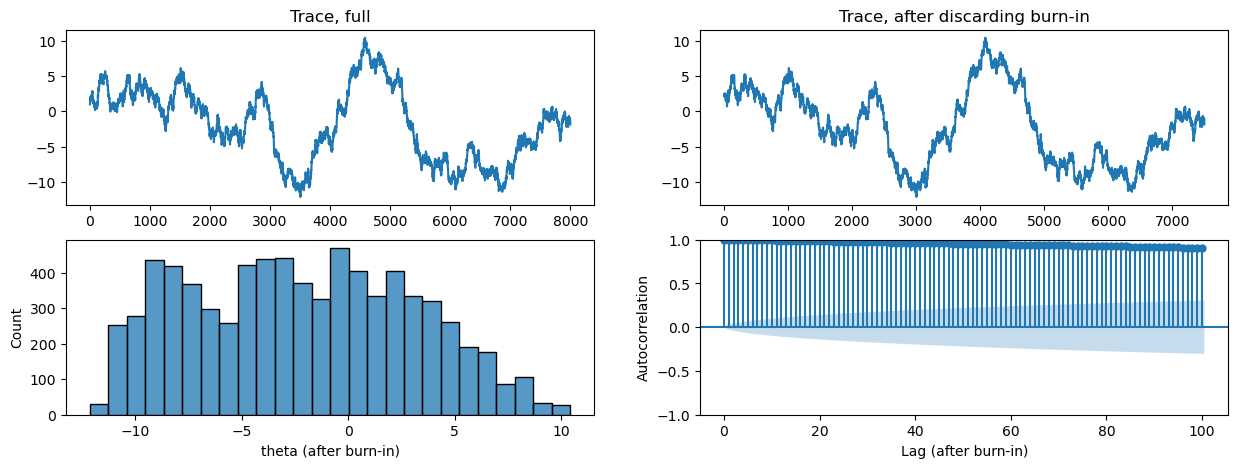

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

def plot_res(xs, burn_in, x_name):
    # plot trace (based on xs), distribution, and autocorrelation

    xs_kept = xs[burn_in:]

    # plot trace full
    fig, ax = plt.subplots(2,2, figsize=(15,5))
    ax[0,0].plot(xs)
    ax[0,0].set_title('Trace, full')

    # plot trace, after burn-in
    ax[0,1].plot(xs_kept)
    ax[0,1].set_title('Trace, after discarding burn-in')

    # plot distribution, after burn-inrt
    sns.histplot(xs_kept, ax=ax[1,0])
    ax[1,0].set_xlabel(f'{x_name} (after burn-in)')

    # plot autocorrelation, after burn-in
    plot_acf(np.array(xs_kept), lags=100, ax=ax[1,1], title='')
    ax[1,1].set_xlabel('Lag (after burn-in)')
    ax[1,1].set_ylabel('Autocorrelation')

plot_res(thetas, 500, 'theta')
print(f"Mean acceptance rate: {np.mean(accept_rates[500:]): .3f}")

# Using PYMC3 Library

In [6]:
import os
import theano

os.environ['MKL_THREADING_LAYER'] = 'GNU'
theano.config.blas__check_openmp = False


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
C:\Users\hp\anaconda3\Lib\site-packages\theano\scalar\basic.py:2412: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [8]:
!pip install numpy==1.20.0

     ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.0 MB 108.9 kB/s eta 0:01:13
     ---------------------------------------- 0.0/8.0 MB 131.3 kB/s eta 0:01:01
     ---------------------------------------- 0.0/8.0 MB 131.3 kB/s eta 0:01:01
     ---------------------------------------- 0.0/8.0 MB 122.9 kB/s eta 0:01:05
     ---------------------------------------- 0.1/8.0 MB 172.4 kB/s eta 0:00:46
     ---------------------------------------- 0.1/8.0 MB 218.5 kB/s eta 0:00:37
      --------------------------------------- 0.1/8.0 MB 262.6 kB/s eta 0:00:30
      --------------------------------------- 0.1/8.0 MB 315.4 kB/s eta 0:00:25
     - -------------------------------------- 0.2/8.0 MB 458.5 kB/s eta 0:00:17
     - -------------------------------------- 0.3/8.0 MB 559.2 kB/s

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [279 lines of output]
  setup.py:66: RuntimeWarning: NumPy 1.20.0 may not yet support Python 3.11.
    warnings.warn(
  Running from numpy source directory.
  setup.py:485: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
    run_build = parse_setuppy_commands()
  Processing numpy/random\_bounded_integers.pxd.in
  Processing numpy/random\bit_generator.pyx
  Processing numpy/random\mtrand.pyx
  Processing numpy/random\_bounded_integers.pyx.in
  Processing numpy/random\_common.pyx
  Processing numpy/random\_generator.pyx
  Processing numpy/random\_mt19937.pyx
  Processing numpy/random\_pcg64.pyx
  Processing numpy/random\_philox.pyx
  Processing numpy/random\_sfc64.pyx
  Cythonizing sources
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying fro